In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.datasets

from tensorflow.python.framework.ops import reset_default_graph

# Plot graph

In [2]:
# plot decision boundary for the model
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    yy = yy.astype('float32')
    xx = xx.astype('float32')
    
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])[:,0]
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 0], X[:, 1], c=-y, cmap=plt.cm.Spectral)

# One hot encoding

In [3]:
def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

# Problem statement

#### We are here to demonstrate that MLPs can classify non-linear problems. FNN will be used to classifiy 2D half-moon datasets.

(3000, 2) (3000,)


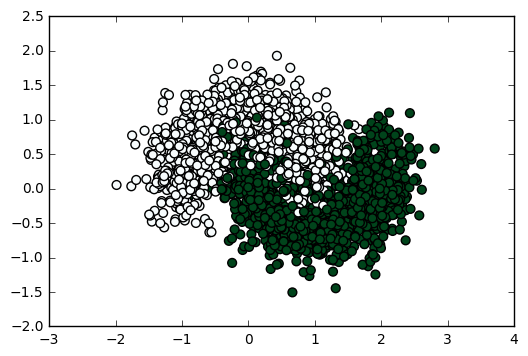

In [4]:
# Generate a dataset and plot it
np.random.seed(0)
num_samples = 9000

# feel free to adjust the noise level of the dataset
# high noise level will be challenging for the model to predict accurately
X, y = sklearn.datasets.make_moons(num_samples, noise=0.30)

X_train = X[:3000].astype('float32')
X_validation = X[3000:6000].astype('float32')
X_test = X[6000:].astype('float32')

y_train = y[:3000].astype('int32')
y_validation = y[3000:6000].astype('int32')
y_test = y[6000:].astype('int32')

plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=plt.cm.BuGn)

print X_train.shape, y_train.shape

num_features = X_train.shape[1]
num_output = 64
num_classes = 2

# Let us contruct feed forward neural network 

In [5]:
# resets the graph, needed when initializing weights multiple times, like in this notebook
reset_default_graph()

# Setting up placeholder, this is where your data enters the graph!
x_pl = tf.placeholder(tf.float32, [None, num_features])

# Setting up variables, these variables are weights in your network that can be update while running our graph.
# Notice, to make a hidden layer, the weights needs to have the following dimensionality
# W[number_of_units_going_in, number_of_units_going_out]
# b[number_of_units_going_out]
# if we want to make a hidden layer with 64 neurons, we need to define the shape of the
# first weight to W[2, 64], b[2] and the shape of the second weight to W[64, 128], b[128]
# and the shape of the third weight to W[128, 2], b[2]

# defining our initializer for our weigths from a normal distribution (mean=0, std=0.1)
weight_initializer = tf.truncated_normal_initializer(stddev=0.1)

with tf.variable_scope('layer_1'):
    W_1 = tf.get_variable('W', [num_features, num_output], initializer=weight_initializer)
    b_1 = tf.get_variable('b', [num_output], initializer=tf.constant_initializer(0.0))
    
with tf.variable_scope('layer_2'):
    W_2 = tf.get_variable('W', [64, 128], initializer=weight_initializer) # use 128 neurons
    b_2 = tf.get_variable('b', [128], initializer=tf.constant_initializer(0.0))

with tf.variable_scope('layer_3'):
    W_3 = tf.get_variable('W', [128, num_classes], initializer=weight_initializer) # follow layer 2
    b_3 = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))

# Setting up ops, these ops will define edges along our computational graph
# The below ops will compute a logistic regression, but can be modified to compute a neural network
layer_1 = tf.matmul(x_pl, W_1) + b_1

# to make a hidden layer we need a nonlinearity
layer_1_nonlinear = tf.nn.relu(layer_1)

# layer 2
layer_2 = tf.matmul(layer_1_nonlinear, W_2) + b_2

# to make a hidden layer we need a nonlinearity
layer_2_nonlinear = tf.nn.relu(layer_2)

# the layer before the softmax should not have a nonlinearity
layer_3 = tf.matmul(layer_2_nonlinear, W_3) + b_3

y = tf.nn.softmax(layer_3) # change to l_2 for MLP

In [6]:
# knowing how to print your tensors and ops is useful, here are some examples
print("---placeholders---")
print(x_pl.name)
print(x_pl)
print

print("---weights---")
print(W_1.name)
print(W_1.get_shape())
print(W_1)
print

print("---bias---")
print(b_1.name)
print(b_1)
print(b_1.get_shape())
print

print("---ops 1---")
print(layer_1.name)
print(layer_1)
print

print(y.name)
print(y)

---placeholders---
Placeholder:0
Tensor("Placeholder:0", shape=(?, 2), dtype=float32)

---weights---
layer_1/W:0
(2, 64)

---bias---
layer_1/b:0
(64,)

---ops 1---
add:0
Tensor("add:0", shape=(?, 64), dtype=float32)

Softmax:0
Tensor("Softmax:0", shape=(?, 2), dtype=float32)


In [7]:
# y_ is a placeholder variable taking on the value of the target batch.
y_ = tf.placeholder(tf.float32, [None, num_classes])

# computing cross entropy per sample
cross_entropy = -tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1])

# averaging over samples
cross_entropy = tf.reduce_mean(cross_entropy)

In [8]:
# select different optimizer for different results
# SGD
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

# Adadelta
# optimizer = tf.train.AdadeltaOptimizer(learning_rate=0.1)

# computing our gradients
grads_and_vars = optimizer.compute_gradients(cross_entropy)

# applying the gradients
train_op = optimizer.apply_gradients(grads_and_vars)

In [9]:
# making a one-hot encoded vector of correct (1) and incorrect (0) predictions
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))

# averaging the one-hot encoded vector
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Epoch 0, Train Cost: 0.696	Val Cost: 0.687	 Val acc: 0.653
Epoch 100, Train Cost: 0.351	Val Cost: 0.344	 Val acc: 0.853
Epoch 200, Train Cost: 0.338	Val Cost: 0.328	 Val acc: 0.857
Epoch 300, Train Cost: 0.332	Val Cost: 0.321	 Val acc: 0.859
Epoch 400, Train Cost: 0.326	Val Cost: 0.315	 Val acc: 0.862
Epoch 500, Train Cost: 0.319	Val Cost: 0.308	 Val acc: 0.867
Epoch 600, Train Cost: 0.310	Val Cost: 0.298	 Val acc: 0.871
Epoch 700, Train Cost: 0.295	Val Cost: 0.282	 Val acc: 0.878
Epoch 800, Train Cost: 0.276	Val Cost: 0.262	 Val acc: 0.888
Epoch 900, Train Cost: 0.257	Val Cost: 0.242	 Val acc: 0.898

Test Cost: 0.236	Test Accuracy: 0.908


(<matplotlib.text.Text at 0x112e9f4d0>, <matplotlib.text.Text at 0x1079cc350>)

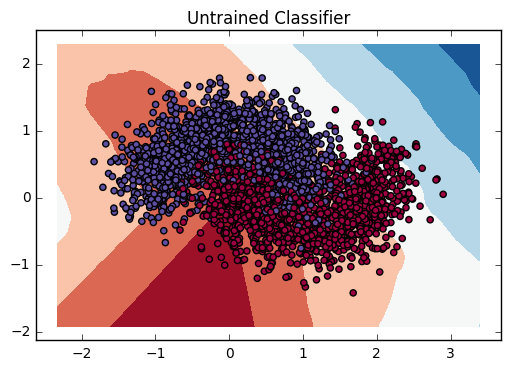

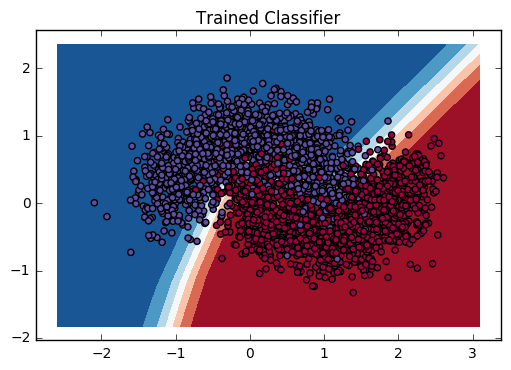

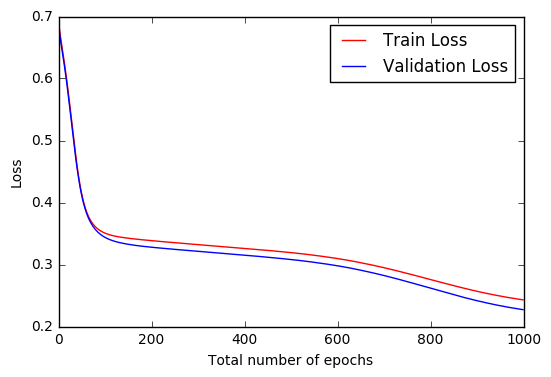

In [10]:
# defining a function to make predictions using our classifier
def pred(X_in, sess):
    # first we must define what data to give it
    feed_dict = {x_pl: X_in}
    
    # secondly our fetches
    fetches = [y]
    
    # utilizing the given session (ref. sess) to compute results
    res = sess.run(fetches, feed_dict)
    
    # res is a list with each indices representing the corresponding element in fetches
    return res[0]

# total number of epochs
num_epochs = 1000

# store the loss and accuracy via list
train_cost = [] 
val_cost = []
val_acc = []

# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=1)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    
    # initializing all variables
    init = tf.initialize_all_variables()
    sess.run(init)
    plot_decision_boundary(lambda x: pred(x, sess), X_validation, y_validation)
    plt.title("Untrained Classifier")
    
    for e in range(num_epochs):
        ### TRAINING ###
        # what to feed to our train_op
        # notice we onehot encode our predictions to change shape from (batch,) -> (batch, num_classes)
        feed_dict_train = {x_pl: X_train, y_: onehot(y_train, num_classes)}
        
        # deciding which parts to fetch, train_op makes the classifier "train"
        fetches_train = [train_op, cross_entropy]
        
        # running the train_op
        res = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
        # storing cross entropy (second fetch argument, so index=1)
        train_cost += [res[1]]
    
        ### VALIDATING ###
        # what to feed our accuracy op
        feed_dict_valid = {x_pl: X_validation, y_: onehot(y_validation, num_classes)}

        # deciding which parts to fetch
        fetches_valid = [cross_entropy, accuracy]

        # running the validation
        res = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
        val_cost += [res[0]]
        val_acc += [res[1]]

        if e % 100 == 0:
            print "Epoch %i, Train Cost: %0.3f\tVal Cost: %0.3f\t Val acc: %0.3f"%(e, train_cost[-1],val_cost[-1],val_acc[-1])

    ### TESTING ###
    # what to feed our accuracy op
    feed_dict_test = {x_pl: X_test, y_: onehot(y_test, num_classes)}

    # deciding which parts to fetch
    fetches_test = [cross_entropy, accuracy]

    # running the validation
    res = sess.run(fetches=fetches_test, feed_dict=feed_dict_test)
    test_cost = res[0]
    test_acc = res[1]
    print "\nTest Cost: %0.3f\tTest Accuracy: %0.3f"%(test_cost, test_acc)
    
    # For plotting purposes
    plot_decision_boundary(lambda x: pred(x, sess), X_test, y_test)

# notice: we do not need to use the session environment anymore, so returning from it.
plt.title("Trained Classifier")

epoch = np.arange(len(train_cost))
plt.figure()
plt.plot(epoch,train_cost,'r',epoch,val_cost,'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Total number of epochs'), plt.ylabel('Loss')